In [39]:
import skimage.io as skio
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage.morphology import disk 
from ipywidgets import interact, widgets
import matplotlib.patches as patches


In [40]:
from skimage.morphology import disk
import skimage.filters

def median(img, mask, size=8):
    """
    Apply a median filter to the image with a specified size and mask.

    Parameters:
    img (ndarray): The input image to be filtered.
    mask (ndarray): A binary mask that specifies the region to apply the filter.
    size (int, optional): The size of the disk-shaped footprint for the median filter. Default is 8.

    Returns:
    ndarray: The image after applying the median filter.
    """
    return skimage.filters.rank.median(img, footprint=disk(size), mask=mask)

def blur(img, scale):
    """
    Apply a Gaussian blur to the image with a specified sigma value.

    Parameters:
    img (ndarray): The input image to be blurred.
    scale (float): The sigma value for the Gaussian filter.

    Returns:
    ndarray: The image after applying the Gaussian blur.
    """
    return skimage.filters.gaussian(img, sigma=scale)

def expand(img, scale):
    """
    Expand the regions in the image by applying a series of blurring and thresholding operations.

    Parameters:
    img (ndarray): The input binary image to be expanded.
    scale (float): The scale factor for the Gaussian blur.

    Returns:
    ndarray: The expanded binary image.
    """
    blurred = (10 * blur(img, scale)) > 0.5
    expanded = ((blurred + img)) > 0
    return blur(expanded, scale / 1.5)

def overlay(img, img2, mask):
    """
    Overlay one image onto another using a binary mask.

    Parameters:
    img (ndarray): The first image to be overlayed.
    img2 (ndarray): The second image to be overlayed.
    mask (ndarray): A binary mask that specifies the region to use from the first image.

    Returns:
    ndarray: The combined image after overlaying.
    """
    img = img * mask
    img2 = img2 * (1 - mask)
    return img + img2


In [41]:
#Importing the image
img = skio.imread("2_altered.jpg")
if img.ndim == 3:
    img = skimage.color.rgb2gray(img)

In [42]:
#Adjusting the format
img = ((img/img.max())*255).astype(np.uint8)

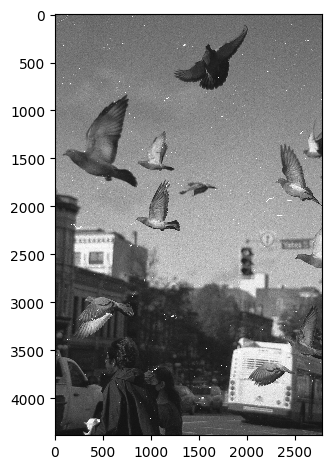

In [43]:
skio.imshow(img)

In [44]:
def remove_dust(img, intensity=6, sig_min=2, sig_max=4, threshold=120, scale=3):
    """
    Remove dust particles from an image using a combination of Gaussian filters, thresholding, and regional median filtering.

    Parameters:
    img (ndarray): The input image from which dust particles are to be removed.
    intensity (int, optional): The size of the disk-shaped footprint for the median filter. Default is 6.
    sig_min (float, optional): The minimum sigma value for the Difference of Gaussian filter. Default is 2.
    sig_max (float, optional): The maximum sigma value for the Difference of Gaussian filter. Default is 4.
    threshold (int, optional): The intensity threshold to separate dust particles from the background. Default is 120.
    scale (float, optional): The scale factor for the expansion process. Default is 3.

    Returns:
    ndarray: The image after removing dust particles.
    """
    dog = abs(skimage.filters.difference_of_gaussians(img, sig_min, sig_max)) > 0.05
    td = img > threshold
    combined = np.logical_and(td, dog)
    combined = expand(combined, scale)
    img2 = median(img, size=intensity, mask=combined > 0)
    return overlay(img2, img, combined).astype(np.uint8)

In [45]:
def preview(img, height, width, size=128):
    """
    Extract a preview window from the image based on the specified height and width ratios.

    Parameters:
    img (ndarray): The input image from which the preview is to be extracted.
    height (float): The height ratio (0 to 1) to determine the vertical position of the preview window.
    width (float): The width ratio (0 to 1) to determine the horizontal position of the preview window.
    size (int, optional): The size of the preview window. Default is 128.

    Returns:
    ndarray: The extracted preview window from the image.
    """
    
    img_height, img_width = img.shape
    
    img_height -= size
    img_width -= size
    
    img_height = round(height * img_height)
    img_width = round(width * img_width)
    
    return img[img_height:img_height+size, img_width:img_width+size]
    
    
    

In [46]:
def compare(img, h, w, intensity=6, sig_min=2, sig_max=4, threshold=120, size=128):
    """
    Compare the original image, the preview window, and the processed image with dust removed.

    Parameters:
    img (ndarray): The input image to be processed.
    h (float): The height ratio (0 to 1) to determine the vertical position of the preview window.
    w (float): The width ratio (0 to 1) to determine the horizontal position of the preview window.
    intensity (int, optional): The size of the disk-shaped footprint for the median filter. Default is 6.
    sig_min (float, optional): The minimum sigma value for the Difference of Gaussian filter. Default is 2.
    sig_max (float, optional): The maximum sigma value for the Difference of Gaussian filter. Default is 4.
    threshold (int, optional): The intensity threshold to separate dust particles from the background. Default is 120.
    size (int, optional): The size of the preview window. Default is 128.

    Returns:
    None
    """    
    y = preview(img, h, w, size=size)
    x = remove_dust(y, intensity=intensity, threshold=threshold, sig_min=sig_min, sig_max=sig_max)
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    rect = patches.Rectangle((w * (img.shape[1]-size), h * (img.shape[0]-size)), size, size, linewidth=1, edgecolor='r', facecolor='none')
    
    axes[0].imshow(y, cmap="gray", vmin=0, vmax=255)
    axes[1].imshow(preview(x, h, w, size=size), cmap="gray", vmin=0, vmax=255)
    axes[2].imshow(img, cmap="gray")
    
    axes[2].add_patch(rect)
    
    plt.show()

# Function to save the processed image
def save_image(event):
    """
    Save the processed image with the current slider values.

    Parameters:
    event (Event): The event that triggers the save action.

    Returns:
    None
    """
    h = height_slider.value
    w = width_slider.value
    size = size_slider.value
    intensity = intensity_slider.value
    sig_min = sig_min_slider.value
    sig_max = sig_max_slider.value
    threshold = threshold_slider.value
    
    # Apply preview and remove_dust with current slider values
    y = img
    processed_img = remove_dust(y, intensity=intensity, threshold=threshold, sig_min=sig_min, sig_max=sig_max)
    
    # Save the processed image
    skio.imsave("cache.jpg", processed_img)
    print("Image saved.")

# Creating interactive sliders for all parameters
height_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Height')
width_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5, description='Width')
size_slider = widgets.IntSlider(min=1, max=512, step=1, value=256, description='Window Size')
intensity_slider = widgets.IntSlider(min=1, max=16, step=1, value=6, description='Intensity')
sig_min_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=2, description='Sigma Min')
sig_max_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=4, description='Sigma Max')
threshold_slider = widgets.IntSlider(min=0, max=255, step=1, value=120, description='Threshold')

interact(compare, 
         img=widgets.fixed(img),
         h=height_slider,
         w=width_slider,
         size=size_slider,
         intensity=intensity_slider,
         sig_min=sig_min_slider,
         sig_max=sig_max_slider,
         threshold=threshold_slider
         )

# Creating save button
save_button = widgets.Button(description="Save Image")
save_button.on_click(save_image)

# Displaying the sliders and button
display(save_button)

interactive(children=(FloatSlider(value=0.5, description='Height', max=1.0, step=0.01), FloatSlider(value=0.5,…

Button(description='Save Image', style=ButtonStyle())